#### Plot N versus z Distributions
This notebook demonstrates how to make number-density versus redshift plots for a set of magnitude ranges.
Features that are demonstrated:
* how to point to a private version of GCRCatalogs
* selection of data quantities to plot
* definition of filters to be applied to the data selection
* use of the GCRCatalogs iterator for large catalogs
* aggregation of histograms on the fly
* looping over sub-plots

The functions in this notebook have been culled from the [NumberDensityVersusRedshift](https://github.com/LSSTDESC/descqa/blob/master/descqa/NumberDensityVersusRedshift.py) DESCQA test.

In [4]:
#set up the environment
import sys
import os
import numpy as np
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
#Add the path to a private version og GCRCatalogs (skip if not using) 
sys.path.insert(0, '/global/u1/k/kovacs/gcr-catalogs_v4x')
import GCRCatalogs
import math                                                                                                                                               
try:                                                                                                                                                      
    from itertools import zip_longest                                                                                                                     
except ImportError:                                                                                                                                       
    from itertools import izip_longest as zip_longest                                                                                                     
from GCR import GCRQuery
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the catalog using GCRCatalogs

In [5]:
gc = GCRCatalogs.load_catalog('proto-dc2_v4.15_test') #load test catalog with private reader
#gc = GCRCatalogs.load_catalog('protoDC2')  #load default catalog


/global/u1/k/kovacs/gcr-catalogs_v4x/GCRCatalogs/alphaq.py:114: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


Define a function to fetch the catalog data for the desired redshift quantity and magnitude in  a specified band. Data will be filtered to lie between selected redshift bounds. Filter magnitudes may come from several specified filters, in the given preferred order.

This function uses a GCR iterator so that data from a very large catalog can be processed. This is not a problem for protoDC2, but will be an issue for cosmoDC2, since that catalog will be too large to fit into memory. The iterator returns the catalog data in chunks. Histogram arrays to store the chunks have to be pre-allocated and accumulated on the fly for each chunk.

Note that because we are accumulating the histograms as we process the data, this function needs arguments that define the binning and the desired shape of the sub-plot array.

We accumulate sumz_array so that it will be possible to calculate the mean of z for each bin.

In [6]:
def get_mags_and_redshift(gc, mag_lo, mag_hi, band='r', z='redshift_true', zlo=0., zhi=1.1, 
                          nrows=3, ncolumns=2, Nzbins=20):
    #setup quantities to fetch
    possible_mag_fields = ('mag_true_{}_lsst', 'mag_true_{}_sdss', 'mag_true_{}_des')
    mag_fields = [f.format(band) for f in possible_mag_fields]
    mag_field = gc.first_available(*mag_fields)
    required_quantities = [mag_field, z]
    zbins = np.linspace(zlo, zhi, Nzbins+1)
    filters = [(lambda z: (z > zlo) & (z < zhi), z)]  #filter on selected redshift range
    
    #initialize arrays for storing histogram sums
    N_array = np.zeros((nrows, ncolumns, len(zbins)-1), dtype=np.int)
    sumz_array = np.zeros((nrows, ncolumns, len(zbins)-1))
    #get catalog data by looping over data iterator (needed for large catalogs) and aggregate histograms
    for catalog_data in gc.get_quantities(required_quantities, filters=filters, return_iterator=True):
        catalog_data = GCRQuery(*((np.isfinite, col) for col in catalog_data)).filter(catalog_data)
        for n, (cut_lo, cut_hi, N, sumz) in enumerate(zip_longest(
                mag_lo,
                mag_hi,
                N_array.reshape(-1, N_array.shape[-1]), #flatten all but last dimension of array
                sumz_array.reshape(-1, sumz_array.shape[-1]),
        )):
            if cut_lo:
                mask = (catalog_data[mag_field] < cut_lo)
                if cut_hi:
                    mask &= (catalog_data[mag_field] >= cut_hi)
                    z_this = catalog_data[z][mask]
                    
                del mask

                #bin catalog_data and accumulate subplot histograms
                N += np.histogram(z_this, bins=zbins)[0]
                sumz += np.histogram(z_this, bins=zbins, weights=z_this)[0]
        
    return zbins, N_array, sumz_array

Now select some magnitude cuts, choose a 2 column array for the subplots, and call the function to accumulate the histogram arrays.

In [7]:
#select some magnitude cuts and fill the histogram arrays for 2-column plots
mlo = 25
mhi = 19
mag_lo = [float(m) for m in range(int(mhi+1), int(mlo+1))]
mag_hi = [float(mhi) for m in range(len(mag_lo))]
ncolumns = 2
nrows = (len(mag_lo) + ncolumns - 1)//ncolumns
#print(mag_lo, mag_hi, nrows)
zbins, N_array, sumz_array = get_mags_and_redshift(gc, mag_lo, mag_hi, nrows=nrows, ncolumns=ncolumns)
#print(zbins, N_array[0, 0], sumz_array[0, 0])

Define a function to make the plots using the accumulated histogram arrays. Statistical errors only are being used. A more realistic estimate would be provided by jack-knife errors which take into account the sample variance. The code for calculating the jack-knife errors is available in the [DESCQA test](https://github.com/LSSTDESC/descqa/blob/master/descqa/NumberDensityVersusRedshift.py).

In [8]:
#make plots
def plot_N_vs_z(mag_lo, mag_hi, N_array, sumz_array, zbins, band='r', normed=True,
                nrows=3, ncolumns=2, figx_p=9, figy_p=11):
    fig, ax = plt.subplots(nrows, ncolumns, figsize=(figx_p, figy_p), sharex='col')
    for n, (ax_this, cut_lo, cut_hi, N, sumz) in enumerate(zip_longest(
            ax.flat,                                                                                                                                      
            mag_lo,                                                                           
            mag_hi,                                                                           
            N_array.reshape(-1, N_array.shape[-1]),                                                
            sumz_array.reshape(-1, sumz_array.shape[-1]),                                                                                 
    )):                                                                                            
        if cut_lo is None:  #cut_lo is None if mag_lo is exhausted                            
            ax_this.set_visible(False)                                                             
        else:
            cut_label = '{} $< {}$'.format(band, cut_lo)
            if cut_hi:
                cut_label = '${} <=$ {}'.format(cut_hi, cut_label)
                meanz = sumz / N
                sumN = N.sum()
                covariance = np.diag(N)
                
                if normed:
                    scale = sumN * (zbins[1:] - zbins[:-1])
                    N = N/scale
                    covariance = covariance/np.outer(scale, scale)

                Nerrors = np.sqrt(np.diag(covariance))
                #print(meanz, N, Nerrors)
                ax_this.errorbar(meanz, N, yerr=Nerrors, label=cut_label, color='blue', fmt='o', ms=4)
                decorate_subplot(ax_this, n, nrows, ncolumns, 'p(z|m)', 'z')
            
    plt.subplots_adjust(hspace=0)
    
def decorate_subplot(ax, nplot, nrows, ncolumns, ylabel, xlabel):
    #add axes and legend              
    if nplot % ncolumns == 0:  #1st column
        ax.set_ylabel('$'+ylabel+'$', size=16)

    if nplot+1 <= nplot - ncolumns:  #x scales for last ncol plots only
        #print "noticks",nplot                                                  
        for axlabel in ax.get_xticklabels():                                    
            axlabel.set_visible(False)                                          
            #prevent overlapping yaxis labels                                   
            ax.yaxis.get_major_ticks()[0].label1.set_visible(False)             
    else:                                                                       
        ax.set_xlabel('$'+xlabel+'$', size=16)                                   
        for axlabel in ax.get_xticklabels():                                    
            axlabel.set_visible(True)                                           
        ax.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10, numpoints=1)
         


/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


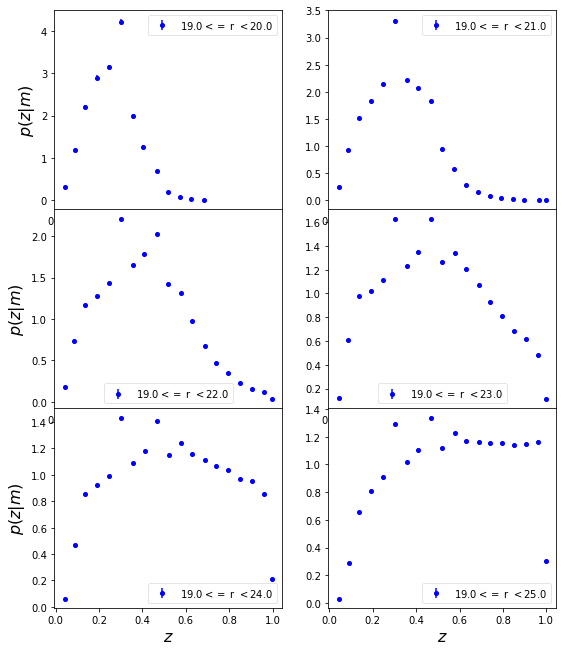

In [9]:
#call the plotting function
plot_N_vs_z(mag_lo, mag_hi, N_array, sumz_array, zbins, nrows=nrows, ncolumns=ncolumns, normed=True)
